In [1]:
import nuclei

In [2]:

import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern


# In[142]:


sys.path.append(os.path.join(os.path.dirname(os.getcwd()),"modules"))


# In[143]:


import NbrRegionSegment as seg



In [3]:
def run(img, withBG = False, path = None):

    if not withBG:
        # Original is given
        if path:
            img = cv.imread(path)

        #Segment Image
        gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        radius = 1
        points = 8*radius 
        lbp = local_binary_pattern(gray_img, points, radius, "uniform").astype("uint8")


        wr, wb, wg, wc = 0.09231725,  0.04552005,  0.7421578, 0.9
        thres = 12
        
        lmap, reg = seg.RegionExtract(img, lbp, thres, wr, wg, wb, wc)

        r_map = seg.GetBgMap(lmap, 1000, reg)

        r_white = np.array(img)
        r_white[r_map] = 255

        gray = cv.cvtColor(r_white, cv.COLOR_BGR2GRAY)

    else :
        #Segmented image with BG as Black
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img[gray == 0] = [255, 255, 255]
        gray[gray == 0] = 255
        r_white = img

    # Otsu thresholding
    _, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    # noise removal, close filled regions
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_CLOSE,kernel, iterations = 2)

    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    _, sure_fg = cv.threshold(dist_transform,0.3*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    # Marker labelling
    _, markers = cv.connectedComponents(sure_fg)

    # # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv.watershed(r_white,markers)

    # create map for image
    outline = np.zeros_like(markers, "uint8")
    outline[markers == -1] = 255
    outline[thresh == 255] = 255

    th = np.mean(gray[outline == 0])*0.75

    outline[gray>th] = 255
    outline[gray<10] = 255

    outline = cv.medianBlur(outline, 5)
    outline[gray>th] = 255

    nuc_mask = outline == 0

    tmp = np.array(r_white, "uint8")

    tmp[nuc_mask] = [0, 255, 0]


    tmp2 = np.zeros_like(r_white, "uint8")

    tmp2[nuc_mask] = r_white[nuc_mask]
    # cv.imshow("imgorg", tmp2)

    # segmented, reg = seg.RegionExtract(tmp2, np.zeros_like(lbp), 50, wr, wg, wb, 1)
    # noise = seg.GetBgMap(segmented, 50, reg)

    # tmp2[~noise] = [255, 0, 0]

    # tmp2 = cv.medianBlur(tmp2, 5)
    # print(np.sum(noise==True))
    # print(reg)
    # print(tmp2)

    cv.imshow("img", tmp2)
    cv.imshow("out", img)
    cv.imshow("img2", tmp)
    cv.waitKey(0)
    return


In [8]:
import FeaturesExtraction.nuclei as fe

In [11]:
wr, wb, wg, wc = 0.09231725,  0.04552005,  0.7421578, 0.9
thres = 12
img = cv.imread(r"D:\Project 2\Project_2\Region_Growing\3.jpg")

gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
radius = 1
points = 8*radius 
lbp = local_binary_pattern(gray_img, points, radius, "uniform").astype("uint8")

r = seg.RemoveBG(img, lbp, thres, 1000, wr, wg, wb, wc)

nuc = fe.SegmentNuclei(r)

In [14]:
from skimage.feature import greycomatrix

In [15]:
glcm = greycomatrix(nuc, [1], [0, 90])

In [18]:
glcm[0, -1, 0, 1]

2912

In [19]:
np.sum(nuc==0)

12470

In [21]:
r, im = cv.connectedComponents(255-nuc)

In [24]:
r

407

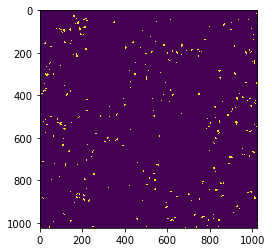

In [23]:
plt.imshow(255-nuc)

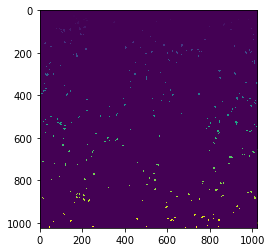

In [22]:
plt.imshow(im)